In [1]:
from xdesign import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec
import os

`polytope` failed to import `cvxopt.glpk`.
Will use `scipy.optimize.linprog`.


# Coverage maps figure with beam gap

Generating beam coverage for a raster scan procedures of different parameters. Only look at the middle `0.5**2` cm because those are the most interesting.

In [2]:
def generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions, folder, nmeta=1, random=False,
                  anisotropy=False):
    """Generate coverage maps for the given angles, pixel fractions, and gap fractions.
    Save the results to numpy files."""
    
    for ang in num_angles:
        for pix in pixel_fractions:
            for gap in gap_fractions:
                
                if anisotropy:
                    file = './data/gap/{}/a{}_{}_{}.npy'.format(folder, ang, pix, gap)
                else:
                    file = './data/gap/{}/{}_{}_{}.npy'.format(folder, ang, pix, gap)

                if not os.path.isfile(file):
                    num_steps = int(gap / probe_width)
                    pixel_size = pix * gap / num_steps
                    n_Riemann = int(np.ceil(16 * probe_width / pixel_size)) 
    #                 print(n_Riemann)

                    procedure = raster_scan(ang, num_steps, width_fraction=gap,
                                            nmeta=nmeta, random=random, plot=True)

                    cmap = coverage_approx(procedure, ROI, pixel_size, n=n_Riemann, anisotropy=anisotropy)

                    np.save(file, cmap)

## Calculate coverage as a function of beam gap

Fix number of angles to 101 and vary the step-size-to-probe-size ratio from 2 to 16.

In [3]:
ROI = [[0.25, 0.75], [0.25, 0.75]] # The region of interest for the coverage map
probe_width = 1/256 # The width of the probe in cm

num_angles = [101] # the number of projection angles
pixel_fractions = [1.] # the pixel size compared to the beam width
gap_fractions = [1./2, 1./4, 1./8, 1./16] # the fraction of space covered by the beam

In [4]:
# default raster scan
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'raster')

In [5]:
# meta-raster scan
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'meta', nmeta=0)

In [6]:
# random meta-raster scan
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'random', nmeta=0, random=True)

In [7]:
def step_size_fig(num_angles):
    """Plot effect of different step sizes"""
    rows = ['raster', 'meta', 'random']
    cols = gap_fractions
    
    fig = plt.figure()

    for i, folder in enumerate(rows):
        for j in range(len(cols)):

            # scale the results as fraction of the most covered pixel
            themap = np.load('./data/gap/{}/{}_{}_{}.npy'.format(folder, num_angles, 1.0, cols[j]))
#             themap /= np.max(themap)
            themap /= 63.3144145097
#             print(np.max(themap), np.min(themap))

            axis = plt.subplot(len(rows), len(cols), i*len(cols) + j + 1)
            plt.imshow(themap)
            plt.gca().get_yaxis().set_ticks([])
            plt.gca().get_xaxis().set_ticks([])


            text = axis.annotate("{:.3f}".format(np.std(themap)),
                                 xy=(0.05,0.05),
                                 xycoords='axes fraction',
                                 color='white',
                                 fontsize=8)

            text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                                   path_effects.Normal()])

            plt.clim([0, 1])
            if j == 0:
                plt.ylabel(str(rows[i]), fontsize=8)
            if i == len(rows) - 1:
                plt.xlabel(str(cols[j]), fontsize=8)
            plt.suptitle('sparsity comparison\nfor {} projection angles'.format(num_angles))
    
    plt.subplots_adjust(wspace=0, hspace=0, left=0.1, right=0.9, bottom=0.1, top=0.9)
    
    return fig

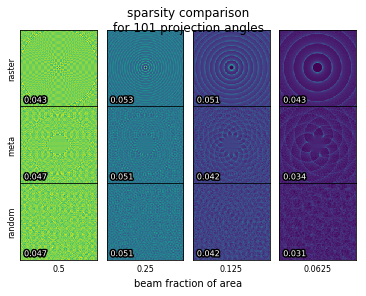

In [8]:
angles = 101
fig = step_size_fig(angles)
fig.text(0.5, 0.0, 'beam fraction of area', ha='center', va='bottom')
plt.savefig('./figures/gap/gap_compare_{}angles.png'.format(angles), format='png',
        transparent=False, bbox_inches=None, pad_inches=0,
        frameon=False)
plt.show()

## Calculate coverage as a function of number of projection angles

See what happens as the number of projection angles goes to infinity for the three paradigms.

In [9]:
num_angles = [11,101,499,1009] #list({int(10**x) for x in np.arange(0, 3.1, 0.1)}) # the number of projection angles
pixel_fractions = [1.] # the pixel size compared to the beam width
gap_fractions = [1./8] # the fraction of space covered by the beam

In [10]:
# default scan
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'raster')
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'meta', nmeta=0)
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'random', nmeta=0, random=True)

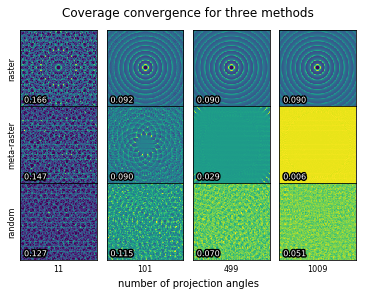

In [11]:
def num_angles_fig():
    num_angles = [11,101,499,1009]

    fig = plt.figure()
    folders = ['raster','meta','random']
    short_names = ['raster', 'meta-raster', 'random']
    cols = sorted(num_angles)
    rows = folders

    for i in range(len(rows)):
        for j in range(len(cols)):

            # scale the results as fraction of the most covered pixel
            themap = np.load('./data/gap/{}/{}_{}_{}.npy'.format(rows[i], cols[j], 1.0, 1./8))
            themap /= np.max(themap)
#             print(np.max(themap), np.min(themap))

            axis = plt.subplot(len(rows), len(cols), i*len(cols) + j + 1)
            plt.imshow(themap)
            plt.gca().get_yaxis().set_ticks([])
            plt.gca().get_xaxis().set_ticks([])


            text = axis.annotate("{:.3f}".format(np.std(themap)),
                                 xy=(0.05,0.05),
                                 xycoords='axes fraction',
                                 color='white',
                                 fontsize=8)

            text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                                   path_effects.Normal()])

            plt.clim([0, 1])
            if j == 0:
                plt.ylabel(str(short_names[i]), fontsize=8)
            if i == len(rows) - 1:
                plt.xlabel(str(cols[j]), fontsize=8)
            plt.suptitle('Coverage convergence for three methods')

    fig.text(0.5, 0.0, 'number of projection angles', ha='center', va='bottom')

    plt.subplots_adjust(wspace=0, hspace=0, left=0.1, right=0.9, bottom=0.1, top=0.9)
    plt.savefig('./figures/gap/raster_converge_select.png', format='png',
            transparent=False, bbox_inches=None, pad_inches=0,
            frameon=False)
    #     return fig
    plt.show()
num_angles_fig()

# Compare the measurement anisotropy of each method

Focus in on a small corner of the second quadrant.

In [12]:
ROI = [[7/16, .5], [7/16, .5]] # The region of interest for the coverage map
probe_width = 1/256
num_angles = [11,53,101,251,499] # the number of projection angles
# num_angles = list({int(10**x) for x in np.arange(0, 3.1, 0.1)}) # the number of projection angles
pixel_fractions = [1.] # the pixel size compared to the beam width
gap_fractions = [1./8] # the fraction of space covered by the beam

In [13]:
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'raster', anisotropy=True)
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'meta', nmeta=0, anisotropy=True)
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'random', nmeta=0, random=True, anisotropy=True)

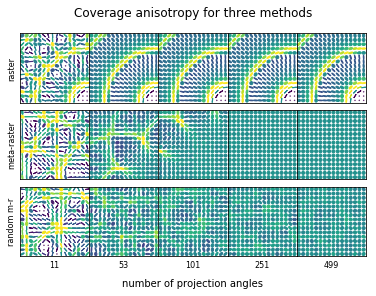

In [14]:
fig = plt.figure()
folders = ['raster','meta','random']
short_names = ['raster', 'meta-raster', 'random m-r']
cols = sorted(num_angles)
rows = folders

for i in range(len(rows)):
    for j in range(len(cols)):

        # scale the results as fraction of the most covered pixel
        themap = np.load('./data/gap/{}/a{}_{}_{}.npy'.format(rows[i], cols[j], 1., 1./8))
#         themap /= np.max(themap)
#             print(np.max(themap), np.min(themap))
#         fig = plt.figure(figsize=(8.85/2.54, 8.85/2.54), dpi=400)
        axis = plt.subplot(len(rows), len(cols), i*len(cols) + j + 1)
        plot_coverage_anisotropy(themap, color='coverage', glyph_density=1, trace_normal=cols[j]/4)
        plt.gca().get_yaxis().set_ticks([])
        plt.gca().get_xaxis().set_ticks([])

        if j == 0:
            plt.ylabel(str(short_names[i]), fontsize=8)
        if i == len(rows) - 1:
            plt.xlabel(str(cols[j]), fontsize=8)
        plt.suptitle('Coverage anisotropy for three methods')

fig.text(0.5, 0.0, 'number of projection angles', ha='center', va='bottom')
        
plt.subplots_adjust(wspace=0, hspace=0, left=0.1, right=0.9, bottom=0.1, top=0.9)
plt.savefig('./figures/gap/raster_anisotropy.png', format='png',
        transparent=False, bbox_inches=None, pad_inches=0,
        frameon=False)
#     return fig
plt.show()